# Modelling Intrusion Detection: Analysis of a Feature Selection Mechanism

## Method Description

### Step 1: Data preprocessing:
All features are made numerical using one-Hot-encoding. The features are scaled to avoid features with large values that may weigh too much in the results.

### Step 2: Feature Selection:
Eliminate redundant and irrelevant data by selecting a subset of relevant features that fully represents the given problem.
Univariate feature selection with ANOVA F-test. This analyzes each feature individually to detemine the strength of the relationship between the feature and labels. Using SecondPercentile method (sklearn.feature_selection) to select features based on percentile of the highest scores. 
When this subset is found: Recursive Feature Elimination (RFE) is applied.

### Step 4: Build the model:
Decision tree model is built.

### Step 5: Prediction & Evaluation (validation):
Using the test data to make predictions of the model.
Multiple scores are considered such as:accuracy score, recall, f-measure, confusion matrix.
perform a 10-fold cross-validation.

## Version Check

In [2]:
import pandas as pd
import numpy as np
import sys
import sklearn
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Lambda
from keras.layers import Embedding
from keras.layers import Convolution1D,MaxPooling1D, Flatten
from keras.datasets import imdb
from keras import backend as K
from sklearn.model_selection import train_test_split
import pandas as pd
from keras.utils.np_utils import to_categorical

from sklearn.preprocessing import Normalizer
from keras.models import Sequential
from keras.layers import Convolution1D, Dense, Dropout, Flatten, MaxPooling1D
from keras.utils import np_utils
import numpy as np
import h5py
from keras import callbacks
from keras.layers import LSTM, GRU, SimpleRNN
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

print(pd.__version__)
print(np.__version__)
print(sys.version)
print(sklearn.__version__)

1.1.2
1.18.5
3.8.3 (default, May 19 2020, 06:50:17) [MSC v.1916 64 bit (AMD64)]
0.23.2


## Load the Dataset

In [3]:
# attach the column names to the dataset
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

# KDDTrain+_2.csv & KDDTest+_2.csv are the datafiles without the last column about the difficulty score
# these have already been removed.
df = pd.read_csv("KDDTrain+_2.csv", header=None, names = col_names)
df_test = pd.read_csv("KDDTest+_2.csv", header=None, names = col_names)

# shape, this gives the dimensions of the dataset
print('Dimensions of the Training set:',df.shape)
print('Dimensions of the Test set:',df_test.shape)

Dimensions of the Training set: (125973, 42)
Dimensions of the Test set: (22544, 42)


## Sample view of the training dataset

In [4]:
# first five rows
df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


## Statistical Summary

In [5]:
df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Label Distribution of Training and Test set

In [6]:
print('Label distribution Training set:')
print(df['label'].value_counts())
print()
print('Label distribution Test set:')
print(df_test['label'].value_counts())

Label distribution Training set:
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64

Label distribution Test set:
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178


# Step 1: Data preprocessing:
One-Hot-Encoding (one-of-K) is used to to transform all categorical features into binary features. 
Requirement for One-Hot-encoding:
"The input to this transformer should be a matrix of integers, denoting the values taken on by categorical (discrete) features. The output will be a sparse matrix where each column corresponds to one possible value of one feature. It is assumed that input features take on values in the range [0, n_values)."

Therefore the features first need to be transformed with LabelEncoder, to transform every category to a number.

## Identify categorical features

In [7]:
# colums that are categorical and not binary yet: protocol_type (column 2), service (column 3), flag (column 4).
# explore categorical features
print('Training set:')
for col_name in df.columns:
    if df[col_name].dtypes == 'object' :
        unique_cat = len(df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

#see how distributed the feature service is, it is evenly distributed and therefore we need to make dummies for all.
print()
print('Distribution of categories in service:')
print(df['service'].value_counts().sort_values(ascending=False).head())

Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'label' has 23 categories

Distribution of categories in service:
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: service, dtype: int64


In [8]:
# Test set
print('Test set:')
for col_name in df_test.columns:
    if df_test[col_name].dtypes == 'object' :
        unique_cat = len(df_test[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 64 categories
Feature 'flag' has 11 categories
Feature 'label' has 38 categories


### Conclusion: Need to make dummies for all categories as the distribution is fairly even. In total: 3+70+11=84 dummies.
### Comparing the results shows that the Test set has fewer categories (6), these need to be added as empty columns.

# LabelEncoder

### Insert categorical features into a 2D numpy array

In [9]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
categorical_columns=['protocol_type', 'service', 'flag']
# insert code to get a list of categorical columns into a variable, categorical_columns
categorical_columns=['protocol_type', 'service', 'flag'] 
 # Get the categorical values into a 2D numpy array
df_categorical_values = df[categorical_columns]
testdf_categorical_values = df_test[categorical_columns]
df_categorical_values.head()

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF


### Make column names for dummies

In [10]:
# protocol type
unique_protocol=sorted(df.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
# service
unique_service=sorted(df.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
# flag
unique_flag=sorted(df.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2
print(dumcols)

#do same for test set
unique_service_test=sorted(df_test.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2

['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'serv

## Transform categorical features into numbers using LabelEncoder()

In [11]:
df_categorical_values_enc=df_categorical_values.apply(LabelEncoder().fit_transform)
print(df_categorical_values_enc.head())
# test set
testdf_categorical_values_enc=testdf_categorical_values.apply(LabelEncoder().fit_transform)

   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9


# One-Hot-Encoding

In [12]:
enc = OneHotEncoder()
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(),columns=dumcols)
# test set
testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(),columns=testdumcols)

df_cat_data.head()

,Protocol_type_icmp,Protocol_type_tcp,Protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Add 6 missing categories from train set to test set

In [13]:
trainservice=df['service'].tolist()
testservice= df_test['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]
difference

['service_http_2784',
 'service_red_i',
 'service_http_8001',
 'service_urh_i',
 'service_harvest',
 'service_aol']

In [14]:
for col in difference:
    testdf_cat_data[col] = 0

testdf_cat_data.shape

(22544, 84)

## Join encoded categorical dataframe with the non-categorical dataframe

In [15]:
newdf=df.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)
# test data
newdf_test=df_test.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)
print(newdf.shape)
print(newdf_test.shape)

(125973, 123)
(22544, 123)


# Split Dataset into 4 datasets for every attack category
## Rename every attack label: 0=normal, 1=DoS, 2=Probe, 3=R2L and 4=U2R.
## Replace labels column with new labels column
## Make new datasets


In [16]:
# take label column
labeldf=newdf['label']
labeldf_test=newdf_test['label']
# change the label column
newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
# put the new label column back
newdf['label'] = newlabeldf
newdf_test['label'] = newlabeldf_test
print(newdf['label'].head())

0    0
1    0
2    1
3    0
4    0
Name: label, dtype: int64


In [17]:
to_drop_DoS = [2,3,4]
to_drop_Probe = [1,3,4]
to_drop_R2L = [1,2,4]
to_drop_U2R = [1,2,3]
DoS_df=newdf[~newdf['label'].isin(to_drop_DoS)];
Probe_df=newdf[~newdf['label'].isin(to_drop_Probe)];
R2L_df=newdf[~newdf['label'].isin(to_drop_R2L)];
U2R_df=newdf[~newdf['label'].isin(to_drop_U2R)];

#test
DoS_df_test=newdf_test[~newdf_test['label'].isin(to_drop_DoS)];
Probe_df_test=newdf_test[~newdf_test['label'].isin(to_drop_Probe)];
R2L_df_test=newdf_test[~newdf_test['label'].isin(to_drop_R2L)];
U2R_df_test=newdf_test[~newdf_test['label'].isin(to_drop_U2R)];
print('Train:')
print('Dimensions of DoS:' ,DoS_df.shape)
print('Dimensions of Probe:' ,Probe_df.shape)
print('Dimensions of R2L:' ,R2L_df.shape)
print('Dimensions of U2R:' ,U2R_df.shape)
print('Test:')
print('Dimensions of DoS:' ,DoS_df_test.shape)
print('Dimensions of Probe:' ,Probe_df_test.shape)
print('Dimensions of R2L:' ,R2L_df_test.shape)
print('Dimensions of U2R:' ,U2R_df_test.shape)

Train:
Dimensions of DoS: (113270, 123)
Dimensions of Probe: (78999, 123)
Dimensions of R2L: (68338, 123)
Dimensions of U2R: (67395, 123)
Test:
Dimensions of DoS: (17171, 123)
Dimensions of Probe: (12132, 123)
Dimensions of R2L: (12596, 123)
Dimensions of U2R: (9778, 123)


# Step 2: Feature Scaling:

In [18]:
# Split dataframes into X & Y
# assign X as a dataframe of feautures and Y as a series of outcome variables
X_DoS = DoS_df.drop('label',1)
Y_DoS = DoS_df.label
X_Probe = Probe_df.drop('label',1)
Y_Probe = Probe_df.label
X_R2L = R2L_df.drop('label',1)
Y_R2L = R2L_df.label
X_U2R = U2R_df.drop('label',1)
Y_U2R = U2R_df.label
# test set
X_DoS_test = DoS_df_test.drop('label',1)
Y_DoS_test = DoS_df_test.label
X_Probe_test = Probe_df_test.drop('label',1)
Y_Probe_test = Probe_df_test.label
X_R2L_test = R2L_df_test.drop('label',1)
Y_R2L_test = R2L_df_test.label
X_U2R_test = U2R_df_test.drop('label',1)
Y_U2R_test = U2R_df_test.label

### Save a list of feature names for later use (it is the same for every attack category). Column names are dropped at this stage.

In [19]:
colNames=list(X_DoS)
colNames_test=list(X_DoS_test)

## Use StandardScaler() to scale the dataframes

In [20]:
from sklearn import preprocessing
scaler1 = preprocessing.StandardScaler().fit(X_DoS)
X_DoS=scaler1.transform(X_DoS) 
scaler2 = preprocessing.StandardScaler().fit(X_Probe)
X_Probe=scaler2.transform(X_Probe) 
scaler3 = preprocessing.StandardScaler().fit(X_R2L)
X_R2L=scaler3.transform(X_R2L) 
scaler4 = preprocessing.StandardScaler().fit(X_U2R)
X_U2R=scaler4.transform(X_U2R) 
# test data
scaler5 = preprocessing.StandardScaler().fit(X_DoS_test)
X_DoS_test=scaler5.transform(X_DoS_test) 
scaler6 = preprocessing.StandardScaler().fit(X_Probe_test)
X_Probe_test=scaler6.transform(X_Probe_test) 
scaler7 = preprocessing.StandardScaler().fit(X_R2L_test)
X_R2L_test=scaler7.transform(X_R2L_test) 
scaler8 = preprocessing.StandardScaler().fit(X_U2R_test)
X_U2R_test=scaler8.transform(X_U2R_test) 

### Check that the Standard Deviation is 1

In [21]:
print(X_DoS.std(axis=0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1.]


In [22]:
X_Probe.std(axis=0);
X_R2L.std(axis=0);
X_U2R.std(axis=0);

# Step 3: Feature Selection:

# 1. Univariate Feature Selection using ANOVA F-test

In [23]:
#univariate feature selection with ANOVA F-test. using secondPercentile method, then RFE
#Scikit-learn exposes feature selection routines as objects that implement the transform method
#SelectPercentile: removes all but a user-specified highest scoring percentage of features
#f_classif: ANOVA F-value between label/feature for classification tasks.
from sklearn.feature_selection import SelectPercentile, f_classif
np.seterr(divide='ignore', invalid='ignore');
selector=SelectPercentile(f_classif, percentile=10)
X_newDoS = selector.fit_transform(X_DoS,Y_DoS)
X_newDoS.shape

c:\users\pedro\miniconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [ 16  44  63  66  68  86 114] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,


(113270, 13)

### Get the features that were selected: DoS

In [24]:
true=selector.get_support()
newcolindex_DoS=[i for i, x in enumerate(true) if x]
newcolname_DoS=list( colNames[i] for i in newcolindex_DoS )
newcolname_DoS

['logged_in',
 'count',
 'serror_rate',
 'srv_serror_rate',
 'same_srv_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'service_http',
 'flag_S0',
 'flag_SF']

In [25]:
X_newProbe = selector.fit_transform(X_Probe,Y_Probe)
X_newProbe.shape

c:\users\pedro\miniconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,


(78999, 13)

### Get the features that were selected: Probe

In [26]:
true=selector.get_support()
newcolindex_Probe=[i for i, x in enumerate(true) if x]
newcolname_Probe=list( colNames[i] for i in newcolindex_Probe )
newcolname_Probe

['logged_in',
 'rerror_rate',
 'srv_rerror_rate',
 'dst_host_srv_count',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'Protocol_type_icmp',
 'service_eco_i',
 'service_private',
 'flag_SF']

In [27]:
X_newR2L = selector.fit_transform(X_R2L,Y_R2L)
X_newR2L.shape

c:\users\pedro\miniconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [  4  16  43  44  46  47  48  49  50  51  54  57  58  62  63  64  66  67
  68  70  71  72  73  74  76  77  78  79  80  81  82  83  86  87  89  92
  93  96  98  99 100 107 108 109 110 114] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,


(68338, 13)

### Get the features that were selected: R2L

In [28]:
true=selector.get_support()
newcolindex_R2L=[i for i, x in enumerate(true) if x]
newcolname_R2L=list( colNames[i] for i in newcolindex_R2L)
newcolname_R2L

['src_bytes',
 'dst_bytes',
 'hot',
 'num_failed_logins',
 'is_guest_login',
 'dst_host_srv_count',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'service_ftp',
 'service_ftp_data',
 'service_http',
 'service_imap4',
 'flag_RSTO']

In [29]:
X_newU2R = selector.fit_transform(X_U2R,Y_U2R)
X_newU2R.shape

c:\users\pedro\miniconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [  4  16  43  44  46  47  48  49  50  51  54  57  58  62  63  64  66  67
  68  70  71  72  73  74  75  76  77  78  79  80  81  82  83  86  87  89
  92  93  96  98  99 100 107 108 109 110 114] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,


(67395, 13)

### Get the features that were selected: U2R

In [30]:
true=selector.get_support()
newcolindex_U2R=[i for i, x in enumerate(true) if x]
newcolname_U2R=list( colNames[i] for i in newcolindex_U2R)
newcolname_U2R

['urgent',
 'hot',
 'root_shell',
 'num_file_creations',
 'num_shells',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'service_ftp_data',
 'service_http',
 'service_telnet']

# Summary of features selected by Univariate Feature Selection

In [31]:
print('Features selected for DoS:',newcolname_DoS)
print()
print('Features selected for Probe:',newcolname_Probe)
print()
print('Features selected for R2L:',newcolname_R2L)
print()
print('Features selected for U2R:',newcolname_U2R)

Features selected for DoS: ['logged_in', 'count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'service_http', 'flag_S0', 'flag_SF']

Features selected for Probe: ['logged_in', 'rerror_rate', 'srv_rerror_rate', 'dst_host_srv_count', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'Protocol_type_icmp', 'service_eco_i', 'service_private', 'flag_SF']

Features selected for R2L: ['src_bytes', 'dst_bytes', 'hot', 'num_failed_logins', 'is_guest_login', 'dst_host_srv_count', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'service_ftp', 'service_ftp_data', 'service_http', 'service_imap4', 'flag_RSTO']

Features selected for U2R: ['urgent', 'hot', 'root_shell', 'num_file_creations', 'num_shells', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_

## The authors state that "After obtaining the adequate number of features during the univariate selection process, a recursive feature elimination (RFE) was operated with the number of features passed as parameter to identify the features selected". This either implies that RFE is only used for obtaining the features previously selected but also obtaining the rank. This use of RFE is however very redundant as the features selected can be obtained in another way (Done in this project). One can also not say that the features were selected by RFE, as it was not used for this. The quote could however also imply that only the number 13 from univariate feature selection was used. RFE is then used for feature selection trying to find the best 13 features. With this use of RFE one can actually say that it was used for feature selection. However the authors obtained different numbers of features for every attack category, 12 for DoS, 15 for Probe, 13 for R2L and 11 for U2R. This concludes that it is not clear what mechanism is used for feature selection. 

## To procede with the data mining, the second option is considered as this uses RFE. From now on the number of features for every attack category is 13.

# 2. Recursive Feature Elimination for feature ranking (Option 1: get importance from previous selected)

In [32]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
# Create a decision tree classifier. By convention, clf means 'classifier'
clf = DecisionTreeClassifier(random_state=0)

#rank all features, i.e continue the elimination until the last one
rfe = RFE(clf, n_features_to_select=1)
rfe.fit(X_newDoS, Y_DoS)
print ("DoS Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_DoS)))

DoS Features sorted by their rank:
[(1, 'same_srv_rate'), (2, 'count'), (3, 'flag_SF'), (4, 'dst_host_serror_rate'), (5, 'dst_host_same_srv_rate'), (6, 'dst_host_srv_count'), (7, 'dst_host_count'), (8, 'logged_in'), (9, 'serror_rate'), (10, 'dst_host_srv_serror_rate'), (11, 'srv_serror_rate'), (12, 'service_http'), (13, 'flag_S0')]


In [33]:
rfe.fit(X_newProbe, Y_Probe)
print ("Probe Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_Probe)))

Probe Features sorted by their rank:
[(1, 'dst_host_same_src_port_rate'), (2, 'dst_host_srv_count'), (3, 'dst_host_rerror_rate'), (4, 'service_private'), (5, 'logged_in'), (6, 'dst_host_diff_srv_rate'), (7, 'dst_host_srv_diff_host_rate'), (8, 'flag_SF'), (9, 'service_eco_i'), (10, 'rerror_rate'), (11, 'Protocol_type_icmp'), (12, 'dst_host_srv_rerror_rate'), (13, 'srv_rerror_rate')]


In [34]:
rfe.fit(X_newR2L, Y_R2L)
 
print ("R2L Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_R2L)))

R2L Features sorted by their rank:
[(1, 'src_bytes'), (2, 'dst_bytes'), (3, 'hot'), (4, 'dst_host_srv_diff_host_rate'), (5, 'service_ftp_data'), (6, 'dst_host_same_src_port_rate'), (7, 'dst_host_srv_count'), (8, 'num_failed_logins'), (9, 'service_imap4'), (10, 'is_guest_login'), (11, 'service_ftp'), (12, 'flag_RSTO'), (13, 'service_http')]


In [35]:
rfe.fit(X_newU2R, Y_U2R)
 
print ("U2R Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_U2R)))

U2R Features sorted by their rank:
[(1, 'hot'), (2, 'dst_host_srv_count'), (3, 'dst_host_count'), (4, 'root_shell'), (5, 'num_shells'), (6, 'service_ftp_data'), (7, 'dst_host_srv_diff_host_rate'), (8, 'num_file_creations'), (9, 'dst_host_same_src_port_rate'), (10, 'service_telnet'), (11, 'srv_diff_host_rate'), (12, 'service_http'), (13, 'urgent')]


# 2. Recursive Feature Elimination, select 13 features each of 122 (Option 2: get 13 best features from 122 from RFE)

In [36]:
from sklearn.feature_selection import RFE
clf = DecisionTreeClassifier(random_state=0)
rfe = RFE(estimator=clf, n_features_to_select=13, step=1)
rfe.fit(X_DoS, Y_DoS)
X_rfeDoS=rfe.transform(X_DoS)
true=rfe.support_
rfecolindex_DoS=[i for i, x in enumerate(true) if x]
rfecolname_DoS=list(colNames[i] for i in rfecolindex_DoS)

In [37]:
rfe.fit(X_Probe, Y_Probe)
X_rfeProbe=rfe.transform(X_Probe)
true=rfe.support_
rfecolindex_Probe=[i for i, x in enumerate(true) if x]
rfecolname_Probe=list(colNames[i] for i in rfecolindex_Probe)

In [38]:
rfe.fit(X_R2L, Y_R2L)
X_rfeR2L=rfe.transform(X_R2L)
true=rfe.support_
rfecolindex_R2L=[i for i, x in enumerate(true) if x]
rfecolname_R2L=list(colNames[i] for i in rfecolindex_R2L)

In [39]:
rfe.fit(X_U2R, Y_U2R)
X_rfeU2R=rfe.transform(X_U2R)
true=rfe.support_
rfecolindex_U2R=[i for i, x in enumerate(true) if x]
rfecolname_U2R=list(colNames[i] for i in rfecolindex_U2R)

# Summary of features selected by RFE

In [40]:
print('Features selected for DoS:',rfecolname_DoS)
print()
print('Features selected for Probe:',rfecolname_Probe)
print()
print('Features selected for R2L:',rfecolname_R2L)
print()
print('Features selected for U2R:',rfecolname_U2R)

Features selected for DoS: ['src_bytes', 'dst_bytes', 'wrong_fragment', 'num_compromised', 'same_srv_rate', 'diff_srv_rate', 'dst_host_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'service_ecr_i', 'flag_RSTR', 'flag_S0']

Features selected for Probe: ['src_bytes', 'dst_bytes', 'rerror_rate', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_rerror_rate', 'service_finger', 'service_ftp_data', 'service_http', 'service_private', 'service_smtp', 'service_telnet']

Features selected for R2L: ['duration', 'src_bytes', 'dst_bytes', 'hot', 'num_failed_logins', 'num_access_files', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'service_ftp_data', 'service_imap4']

Features selected for U2R: ['duration', 'src_bytes', 'dst_bytes', 'hot', 'root_shell', 'num_file_creations', 'num_shells', 'srv_count', 'dst_host_count', 'dst_host_same_sr

In [41]:
print(X_rfeDoS.shape)
print(X_rfeProbe.shape)
print(X_rfeR2L.shape)
print(X_rfeU2R.shape)

(113270, 13)
(78999, 13)
(68338, 13)
(67395, 13)


# Step 4: Build the model:
### Classifier is trained for all features and for reduced features, for later comparison.
#### The classifier model itself is stored in the clf variable.

In [41]:
# all features
clf_DoS=DecisionTreeClassifier(random_state=0)
clf_Probe=DecisionTreeClassifier(random_state=0)
clf_R2L=DecisionTreeClassifier(random_state=0)
clf_U2R=DecisionTreeClassifier(random_state=0)
clf_DoS.fit(X_DoS, Y_DoS)
clf_Probe.fit(X_Probe, Y_Probe)
clf_R2L.fit(X_R2L, Y_R2L)
clf_U2R.fit(X_U2R, Y_U2R)

DecisionTreeClassifier(random_state=0)

In [42]:
# selected features
clf_rfeDoS=DecisionTreeClassifier(random_state=0)
clf_rfeProbe=DecisionTreeClassifier(random_state=0)
clf_rfeR2L=DecisionTreeClassifier(random_state=0)
clf_rfeU2R=DecisionTreeClassifier(random_state=0)
clf_rfeDoS.fit(X_rfeDoS, Y_DoS)
clf_rfeProbe.fit(X_rfeProbe, Y_Probe)
clf_rfeR2L.fit(X_rfeR2L, Y_R2L)
clf_rfeU2R.fit(X_rfeU2R, Y_U2R)

DecisionTreeClassifier(random_state=0)

# Step 5: Prediction & Evaluation (validation):

# Using all Features for each category

# Confusion Matrices
## DoS

In [43]:
# Apply the classifier we trained to the test data (which it has never seen before)
clf_DoS.predict(X_DoS_test)

array([1, 1, 0, ..., 0, 0, 0], dtype=int64)

In [44]:
# View the predicted probabilities of the first 10 observations
clf_DoS.predict_proba(X_DoS_test)[0:10]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [45]:
Y_DoS_pred=clf_DoS.predict(X_DoS_test)
# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,1
Actual attacks,,
0,9499,212
1,2830,4630


## Probe

In [46]:
Y_Probe_pred=clf_Probe.predict(X_Probe_test)
# Create confusion matrix
pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,2
Actual attacks,,
0,2337,7374
2,212,2209


## R2L

In [47]:
Y_R2L_pred=clf_R2L.predict(X_R2L_test)
# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,3
Actual attacks,,
0,9707,4
3,2573,312


## U2R

In [48]:
Y_U2R_pred=clf_U2R.predict(X_U2R_test)
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,4
Actual attacks,,
0,9703,8
4,60,7


# Cross Validation: Accuracy, Precision, Recall, F-measure

## DoS

In [49]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
accuracy = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99639 (+/- 0.00341)
Precision: 0.99505 (+/- 0.00477)
Recall: 0.99665 (+/- 0.00483)
F-measure: 0.99585 (+/- 0.00392)


## Probe

In [50]:
accuracy = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99571 (+/- 0.00328)
Precision: 0.99392 (+/- 0.00684)
Recall: 0.99267 (+/- 0.00405)
F-measure: 0.99329 (+/- 0.00512)


## R2L

In [51]:
accuracy = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.97920 (+/- 0.01053)
Precision: 0.97151 (+/- 0.01736)
Recall: 0.96958 (+/- 0.01379)
F-measure: 0.97051 (+/- 0.01478)


## U2R

In [52]:
accuracy = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99652 (+/- 0.00228)
Precision: 0.86295 (+/- 0.08961)
Recall: 0.90958 (+/- 0.09211)
F-measure: 0.88210 (+/- 0.06559)


# RFECV for illustration

In [53]:
%matplotlib inline

Automatically created module for IPython interactive environment


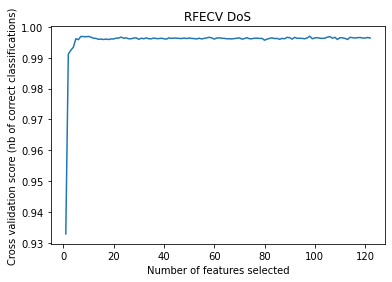

In [54]:
print(__doc__)

import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv_DoS = RFECV(estimator=clf_DoS, step=1, cv=10, scoring='accuracy')
rfecv_DoS.fit(X_DoS_test, Y_DoS_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV DoS')
plt.plot(range(1, len(rfecv_DoS.grid_scores_) + 1), rfecv_DoS.grid_scores_)
plt.show()

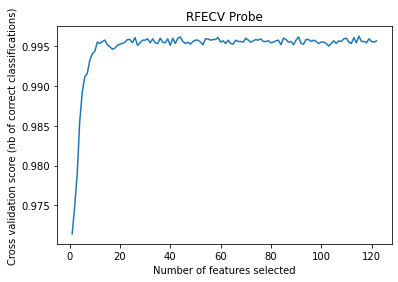

In [55]:
rfecv_Probe = RFECV(estimator=clf_Probe, step=1, cv=10, scoring='accuracy')
rfecv_Probe.fit(X_Probe_test, Y_Probe_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV Probe')
plt.plot(range(1, len(rfecv_Probe.grid_scores_) + 1), rfecv_Probe.grid_scores_)
plt.show()

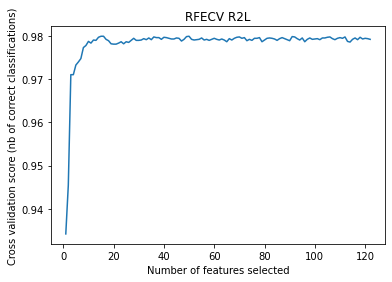

In [56]:
rfecv_R2L = RFECV(estimator=clf_R2L, step=1, cv=10, scoring='accuracy')
rfecv_R2L.fit(X_R2L_test, Y_R2L_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV R2L')
plt.plot(range(1, len(rfecv_R2L.grid_scores_) + 1), rfecv_R2L.grid_scores_)
plt.show()

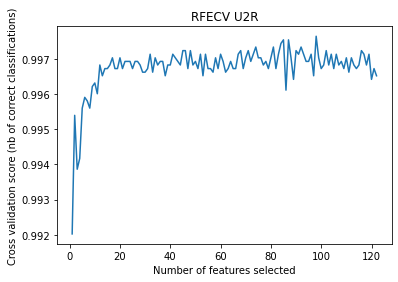

In [57]:
rfecv_U2R = RFECV(estimator=clf_U2R, step=1, cv=10, scoring='accuracy')
rfecv_U2R.fit(X_U2R_test, Y_U2R_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV U2R')
plt.plot(range(1, len(rfecv_U2R.grid_scores_) + 1), rfecv_U2R.grid_scores_)
plt.show()

# Using 13 Features for each category

# Confusion Matrices
## DoS

In [58]:
# reduce test dataset to 13 features, use only features described in rfecolname_DoS etc.
X_DoS_test2=X_DoS_test[:,rfecolindex_DoS]
X_Probe_test2=X_Probe_test[:,rfecolindex_Probe]
X_R2L_test2=X_R2L_test[:,rfecolindex_R2L]
X_U2R_test2=X_U2R_test[:,rfecolindex_U2R]
X_U2R_test2.shape

(9778, 13)

In [59]:
Y_DoS_pred2=clf_rfeDoS.predict(X_DoS_test2)
# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred2, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,1
Actual attacks,,
0,9602,109
1,2625,4835


## Probe

In [60]:
Y_Probe_pred2=clf_rfeProbe.predict(X_Probe_test2)
# Create confusion matrix
pd.crosstab(Y_Probe_test, Y_Probe_pred2, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,2
Actual attacks,,
0,8709,1002
2,944,1477


## R2L

In [61]:
Y_R2L_pred2=clf_rfeR2L.predict(X_R2L_test2)
# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred2, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,3
Actual attacks,,
0,9649,62
3,2560,325


## U2R

In [62]:
Y_U2R_pred2=clf_rfeU2R.predict(X_U2R_test2)
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred2, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,4
Actual attacks,,
0,9706,5
4,52,15


# Cross Validation: Accuracy, Precision, Recall, F-measure

## DoS

In [63]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99738 (+/- 0.00267)
Precision: 0.99692 (+/- 0.00492)
Recall: 0.99705 (+/- 0.00356)
F-measure: 0.99698 (+/- 0.00307)


## Probe

In [64]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99085 (+/- 0.00559)
Precision: 0.98674 (+/- 0.01179)
Recall: 0.98467 (+/- 0.01026)
F-measure: 0.98566 (+/- 0.00871)


## R2L

In [65]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.97459 (+/- 0.00910)
Precision: 0.96689 (+/- 0.01311)
Recall: 0.96086 (+/- 0.01571)
F-measure: 0.96379 (+/- 0.01305)


## U2R

In [66]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99652 (+/- 0.00278)
Precision: 0.87538 (+/- 0.15433)
Recall: 0.89540 (+/- 0.14777)
F-measure: 0.87731 (+/- 0.09647)


# Stratified CV => Stays the same

In [67]:
from sklearn.model_selection import StratifiedKFold
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=StratifiedKFold(10), scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99738 (+/- 0.00267)


In [68]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=StratifiedKFold(10), scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99085 (+/- 0.00559)


In [69]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=StratifiedKFold(10), scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.97459 (+/- 0.00910)


In [70]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=StratifiedKFold(10), scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99652 (+/- 0.00278)


# CV 2, 5, 10, 30, 50 fold

## DoS

In [71]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=2, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99662 (+/- 0.00116)


In [72]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=5, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99709 (+/- 0.00064)


In [73]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99738 (+/- 0.00267)


In [74]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=30, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99726 (+/- 0.00430)


In [75]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=50, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99703 (+/- 0.00622)


## Probe

In [76]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=2, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99060 (+/- 0.00165)


In [77]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=5, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99093 (+/- 0.00233)


In [78]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99085 (+/- 0.00559)


In [79]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=30, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99118 (+/- 0.00742)


In [80]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=50, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99085 (+/- 0.01122)


## R2L

In [81]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=2, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.97118 (+/- 0.00143)


In [82]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=5, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.97388 (+/- 0.00624)


In [83]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.97459 (+/- 0.00910)


In [84]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=30, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.97467 (+/- 0.01644)


In [85]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=50, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.97523 (+/- 0.01795)


## U2R

In [86]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=2, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99519 (+/- 0.00184)


In [87]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=5, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99714 (+/- 0.00153)


In [88]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99652 (+/- 0.00278)


In [89]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=30, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99693 (+/- 0.00571)


In [90]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=50, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99662 (+/- 0.00755)


<h1>CNN</h1>

<h2>Passo 1: preparando os dados</h2>

In [160]:
X_train = newdf.drop('label',1)
Y_train = to_categorical(newdf.label, num_classes=5)
# test set
X_test = newdf_test.drop('label',1)
Y_test = to_categorical(newdf_test.label, num_classes=5)

In [161]:
colNames2=list(X_train)
colNames_test2=list(X_test)


In [162]:
scalerAll = Normalizer().fit(X_train)
X_train = scalerAll.transform(X_train)
X_test = scalerAll.transform(X_test)


In [163]:
X_test.shape

(22544, 122)

<h2>Construindo a CNN</h2>

In [164]:
model = Sequential()
model.add(Convolution1D(64, 3, padding="same",activation="relu",input_shape=(122, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(5, activation="softmax"))

In [165]:
#definindo o "optimizer" e o objetivo, compilando a CNN
model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=['accuracy'])

In [166]:
# train
x_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
x_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
model.fit(x_train, Y_train, batch_size=64, epochs=1000, validation_data=(x_test, Y_test))


Epoch 1/1000
1969/1969 [==============================] - 14s 7ms/step - loss: 0.2713 - accuracy: 0.9127 - val_loss: 1.4546 - val_accuracy: 0.6980
Epoch 2/1000
1969/1969 [==============================] - 14s 7ms/step - loss: 0.1578 - accuracy: 0.9490 - val_loss: 1.7419 - val_accuracy: 0.7166
Epoch 3/1000
1969/1969 [==============================] - 14s 7ms/step - loss: 0.1215 - accuracy: 0.9612 - val_loss: 1.8539 - val_accuracy: 0.7289
Epoch 4/1000
1969/1969 [==============================] - 14s 7ms/step - loss: 0.1037 - accuracy: 0.9676 - val_loss: 1.9915 - val_accuracy: 0.7429
Epoch 5/1000
1969/1969 [==============================] - 16s 8ms/step - loss: 0.0907 - accuracy: 0.9721 - val_loss: 2.1054 - val_accuracy: 0.7222
Epoch 6/1000
1969/1969 [==============================] - 19s 10ms/step - loss: 0.0812 - accuracy: 0.9749 - val_loss: 2.2632 - val_accuracy: 0.7284
Epoch 7/1000
1969/1969 [==============================] - 17s 8ms/step - loss: 0.0754 - accuracy: 0.9768 - val_loss: 

1969/1969 [==============================] - 14s 7ms/step - loss: 0.0173 - accuracy: 0.9948 - val_loss: 5.4756 - val_accuracy: 0.7623
Epoch 112/1000
1969/1969 [==============================] - 13s 7ms/step - loss: 0.0169 - accuracy: 0.9951 - val_loss: 5.5745 - val_accuracy: 0.7645
Epoch 113/1000
1969/1969 [==============================] - 13s 7ms/step - loss: 0.0170 - accuracy: 0.9948 - val_loss: 5.6420 - val_accuracy: 0.7620
Epoch 114/1000
1969/1969 [==============================] - 13s 7ms/step - loss: 0.0175 - accuracy: 0.9947 - val_loss: 5.2130 - val_accuracy: 0.7762
Epoch 115/1000
1969/1969 [==============================] - 14s 7ms/step - loss: 0.0176 - accuracy: 0.9948 - val_loss: 5.3589 - val_accuracy: 0.7632
Epoch 116/1000
1969/1969 [==============================] - 15s 7ms/step - loss: 0.0173 - accuracy: 0.9949 - val_loss: 5.8884 - val_accuracy: 0.7432
Epoch 117/1000
1969/1969 [==============================] - 15s 8ms/step - loss: 0.0172 - accuracy: 0.9951 - val_loss: 5.

1969/1969 [==============================] - 14s 7ms/step - loss: 0.0158 - accuracy: 0.9954 - val_loss: 6.2396 - val_accuracy: 0.7610
Epoch 167/1000
1969/1969 [==============================] - 14s 7ms/step - loss: 0.0154 - accuracy: 0.9953 - val_loss: 6.9878 - val_accuracy: 0.7602
Epoch 168/1000
1969/1969 [==============================] - 14s 7ms/step - loss: 0.0170 - accuracy: 0.9949 - val_loss: 5.8599 - val_accuracy: 0.7534
Epoch 169/1000
1969/1969 [==============================] - 14s 7ms/step - loss: 0.0157 - accuracy: 0.9953 - val_loss: 6.5754 - val_accuracy: 0.7594
Epoch 170/1000
1969/1969 [==============================] - 14s 7ms/step - loss: 0.0145 - accuracy: 0.9956 - val_loss: 6.2766 - val_accuracy: 0.7610
Epoch 171/1000
1969/1969 [==============================] - 14s 7ms/step - loss: 0.0158 - accuracy: 0.9955 - val_loss: 6.8477 - val_accuracy: 0.7547
Epoch 172/1000
1969/1969 [==============================] - 13s 7ms/step - loss: 0.0156 - accuracy: 0.9953 - val_loss: 6.

1969/1969 [==============================] - 14s 7ms/step - loss: 0.0149 - accuracy: 0.9956 - val_loss: 6.3882 - val_accuracy: 0.7645
Epoch 222/1000
1969/1969 [==============================] - 14s 7ms/step - loss: 0.0150 - accuracy: 0.9955 - val_loss: 7.2369 - val_accuracy: 0.7587
Epoch 223/1000
1969/1969 [==============================] - 13s 7ms/step - loss: 0.0147 - accuracy: 0.9957 - val_loss: 6.7855 - val_accuracy: 0.7597
Epoch 224/1000
1969/1969 [==============================] - 13s 7ms/step - loss: 0.0148 - accuracy: 0.9956 - val_loss: 5.7296 - val_accuracy: 0.7600
Epoch 225/1000
1969/1969 [==============================] - 13s 7ms/step - loss: 0.0145 - accuracy: 0.9957 - val_loss: 8.6112 - val_accuracy: 0.7452
Epoch 226/1000
1969/1969 [==============================] - 14s 7ms/step - loss: 0.0142 - accuracy: 0.9957 - val_loss: 6.2138 - val_accuracy: 0.7608
Epoch 227/1000
1969/1969 [==============================] - 15s 7ms/step - loss: 0.0140 - accuracy: 0.9957 - val_loss: 7.

1969/1969 [==============================] - 14s 7ms/step - loss: 0.0136 - accuracy: 0.9960 - val_loss: 8.5032 - val_accuracy: 0.7573
Epoch 277/1000
1969/1969 [==============================] - 13s 7ms/step - loss: 0.0138 - accuracy: 0.9960 - val_loss: 6.9161 - val_accuracy: 0.7592
Epoch 278/1000
1969/1969 [==============================] - 14s 7ms/step - loss: 0.0138 - accuracy: 0.9958 - val_loss: 7.7801 - val_accuracy: 0.7558
Epoch 279/1000
1969/1969 [==============================] - 14s 7ms/step - loss: 0.0141 - accuracy: 0.9958 - val_loss: 7.1866 - val_accuracy: 0.7601
Epoch 280/1000
1969/1969 [==============================] - 14s 7ms/step - loss: 0.0136 - accuracy: 0.9959 - val_loss: 8.4243 - val_accuracy: 0.7523
Epoch 281/1000
1969/1969 [==============================] - 14s 7ms/step - loss: 0.0134 - accuracy: 0.9960 - val_loss: 7.9306 - val_accuracy: 0.7475
Epoch 282/1000
1969/1969 [==============================] - 14s 7ms/step - loss: 0.0131 - accuracy: 0.9960 - val_loss: 8.

1969/1969 [==============================] - 15s 8ms/step - loss: 0.0135 - accuracy: 0.9958 - val_loss: 7.7127 - val_accuracy: 0.7613
Epoch 332/1000
1969/1969 [==============================] - 16s 8ms/step - loss: 0.0133 - accuracy: 0.9959 - val_loss: 7.0970 - val_accuracy: 0.7579
Epoch 333/1000
1969/1969 [==============================] - 15s 8ms/step - loss: 0.0136 - accuracy: 0.9959 - val_loss: 7.9191 - val_accuracy: 0.7466
Epoch 334/1000
1969/1969 [==============================] - 15s 7ms/step - loss: 0.0127 - accuracy: 0.9961 - val_loss: 7.9078 - val_accuracy: 0.7621
Epoch 335/1000
1969/1969 [==============================] - 15s 8ms/step - loss: 0.0130 - accuracy: 0.9961 - val_loss: 8.7436 - val_accuracy: 0.7597
Epoch 336/1000
1969/1969 [==============================] - 15s 8ms/step - loss: 0.0135 - accuracy: 0.9957 - val_loss: 8.1440 - val_accuracy: 0.7642
Epoch 337/1000
1969/1969 [==============================] - 15s 7ms/step - loss: 0.0137 - accuracy: 0.9959 - val_loss: 6.

Epoch 386/1000
1969/1969 [==============================] - 23s 11ms/step - loss: 0.0124 - accuracy: 0.9963 - val_loss: 7.1188 - val_accuracy: 0.7677
Epoch 387/1000
1969/1969 [==============================] - 19s 10ms/step - loss: 0.0131 - accuracy: 0.9960 - val_loss: 7.8344 - val_accuracy: 0.7586
Epoch 388/1000
1969/1969 [==============================] - 17s 9ms/step - loss: 0.0126 - accuracy: 0.9963 - val_loss: 8.0883 - val_accuracy: 0.7506
Epoch 389/1000
1969/1969 [==============================] - 17s 8ms/step - loss: 0.0134 - accuracy: 0.9960 - val_loss: 8.5951 - val_accuracy: 0.7627
Epoch 390/1000
1969/1969 [==============================] - 17s 9ms/step - loss: 0.0127 - accuracy: 0.9963 - val_loss: 9.6302 - val_accuracy: 0.7528
Epoch 391/1000
1969/1969 [==============================] - 15s 8ms/step - loss: 0.0131 - accuracy: 0.9961 - val_loss: 9.4308 - val_accuracy: 0.7602
Epoch 392/1000
1969/1969 [==============================] - 16s 8ms/step - loss: 0.0122 - accuracy: 0.99

Epoch 441/1000
1969/1969 [==============================] - 15s 8ms/step - loss: 0.0123 - accuracy: 0.9962 - val_loss: 8.9191 - val_accuracy: 0.7488
Epoch 442/1000
1969/1969 [==============================] - 15s 7ms/step - loss: 0.0130 - accuracy: 0.9960 - val_loss: 9.2290 - val_accuracy: 0.7548
Epoch 443/1000
1969/1969 [==============================] - 15s 8ms/step - loss: 0.0133 - accuracy: 0.9958 - val_loss: 7.6859 - val_accuracy: 0.7571
Epoch 444/1000
1969/1969 [==============================] - 17s 9ms/step - loss: 0.0127 - accuracy: 0.9964 - val_loss: 8.6793 - val_accuracy: 0.7593
Epoch 445/1000
1969/1969 [==============================] - 17s 9ms/step - loss: 0.0137 - accuracy: 0.9961 - val_loss: 8.6358 - val_accuracy: 0.7603
Epoch 446/1000
1969/1969 [==============================] - 17s 8ms/step - loss: 0.0126 - accuracy: 0.9963 - val_loss: 8.2261 - val_accuracy: 0.7585
Epoch 447/1000
1969/1969 [==============================] - 16s 8ms/step - loss: 0.0131 - accuracy: 0.9961

Epoch 496/1000
1969/1969 [==============================] - 15s 8ms/step - loss: 0.0126 - accuracy: 0.9962 - val_loss: 8.7713 - val_accuracy: 0.7530
Epoch 497/1000
1969/1969 [==============================] - 15s 8ms/step - loss: 0.0129 - accuracy: 0.9962 - val_loss: 7.6295 - val_accuracy: 0.7526
Epoch 498/1000
1969/1969 [==============================] - 15s 7ms/step - loss: 0.0134 - accuracy: 0.9961 - val_loss: 8.7473 - val_accuracy: 0.7648
Epoch 499/1000
1969/1969 [==============================] - 15s 8ms/step - loss: 0.0121 - accuracy: 0.9965 - val_loss: 8.0405 - val_accuracy: 0.7579
Epoch 500/1000
1969/1969 [==============================] - 18s 9ms/step - loss: 0.0124 - accuracy: 0.9963 - val_loss: 7.8159 - val_accuracy: 0.7630
Epoch 501/1000
1969/1969 [==============================] - 17s 8ms/step - loss: 0.0122 - accuracy: 0.9963 - val_loss: 8.3087 - val_accuracy: 0.7496
Epoch 502/1000
1969/1969 [==============================] - 16s 8ms/step - loss: 0.0128 - accuracy: 0.9963

Epoch 551/1000
1969/1969 [==============================] - 16s 8ms/step - loss: 0.0130 - accuracy: 0.9964 - val_loss: 7.8799 - val_accuracy: 0.7514
Epoch 552/1000
1969/1969 [==============================] - 16s 8ms/step - loss: 0.0113 - accuracy: 0.9965 - val_loss: 9.1898 - val_accuracy: 0.7497
Epoch 553/1000
1969/1969 [==============================] - 15s 7ms/step - loss: 0.0120 - accuracy: 0.9964 - val_loss: 8.6669 - val_accuracy: 0.7532
Epoch 554/1000
1969/1969 [==============================] - 15s 7ms/step - loss: 0.0122 - accuracy: 0.9965 - val_loss: 8.4271 - val_accuracy: 0.7517
Epoch 555/1000
1969/1969 [==============================] - 16s 8ms/step - loss: 0.0123 - accuracy: 0.9963 - val_loss: 9.0255 - val_accuracy: 0.7516
Epoch 556/1000
1969/1969 [==============================] - 19s 10ms/step - loss: 0.0116 - accuracy: 0.9963 - val_loss: 9.9473 - val_accuracy: 0.7624
Epoch 557/1000
1969/1969 [==============================] - 17s 8ms/step - loss: 0.0126 - accuracy: 0.996

Epoch 606/1000
1969/1969 [==============================] - 15s 8ms/step - loss: 0.0112 - accuracy: 0.9967 - val_loss: 9.3999 - val_accuracy: 0.7595
Epoch 607/1000
1969/1969 [==============================] - 16s 8ms/step - loss: 0.0119 - accuracy: 0.9963 - val_loss: 9.7932 - val_accuracy: 0.7531
Epoch 608/1000
1969/1969 [==============================] - 15s 7ms/step - loss: 0.0123 - accuracy: 0.9964 - val_loss: 8.8892 - val_accuracy: 0.7646
Epoch 609/1000
1969/1969 [==============================] - 15s 7ms/step - loss: 0.0119 - accuracy: 0.9964 - val_loss: 9.0733 - val_accuracy: 0.7505
Epoch 610/1000
1969/1969 [==============================] - 16s 8ms/step - loss: 0.0119 - accuracy: 0.9963 - val_loss: 10.5368 - val_accuracy: 0.7563
Epoch 611/1000
1969/1969 [==============================] - 18s 9ms/step - loss: 0.0111 - accuracy: 0.9964 - val_loss: 10.5390 - val_accuracy: 0.7584
Epoch 612/1000
1969/1969 [==============================] - 16s 8ms/step - loss: 0.0115 - accuracy: 0.99

Epoch 661/1000
1969/1969 [==============================] - 15s 8ms/step - loss: 0.0112 - accuracy: 0.9966 - val_loss: 9.2215 - val_accuracy: 0.7527
Epoch 662/1000
1969/1969 [==============================] - 16s 8ms/step - loss: 0.0115 - accuracy: 0.9966 - val_loss: 8.9676 - val_accuracy: 0.7624
Epoch 663/1000
1969/1969 [==============================] - 15s 8ms/step - loss: 0.0124 - accuracy: 0.9965 - val_loss: 10.0923 - val_accuracy: 0.7563
Epoch 664/1000
1969/1969 [==============================] - 15s 8ms/step - loss: 0.0118 - accuracy: 0.9964 - val_loss: 9.6973 - val_accuracy: 0.7583
Epoch 665/1000
1969/1969 [==============================] - 17s 9ms/step - loss: 0.0118 - accuracy: 0.9964 - val_loss: 9.9653 - val_accuracy: 0.7605
Epoch 666/1000
1969/1969 [==============================] - 18s 9ms/step - loss: 0.0127 - accuracy: 0.9962 - val_loss: 9.0010 - val_accuracy: 0.7513
Epoch 667/1000
1969/1969 [==============================] - 17s 9ms/step - loss: 0.0113 - accuracy: 0.996

Epoch 716/1000
1969/1969 [==============================] - 15s 8ms/step - loss: 0.0113 - accuracy: 0.9968 - val_loss: 9.4655 - val_accuracy: 0.7555
Epoch 717/1000
1969/1969 [==============================] - 15s 8ms/step - loss: 0.0118 - accuracy: 0.9962 - val_loss: 9.2386 - val_accuracy: 0.7549
Epoch 718/1000
1969/1969 [==============================] - 15s 8ms/step - loss: 0.0121 - accuracy: 0.9965 - val_loss: 10.8899 - val_accuracy: 0.7542
Epoch 719/1000
1969/1969 [==============================] - 16s 8ms/step - loss: 0.0112 - accuracy: 0.9965 - val_loss: 9.7460 - val_accuracy: 0.7531
Epoch 720/1000
1969/1969 [==============================] - 19s 10ms/step - loss: 0.0112 - accuracy: 0.9967 - val_loss: 8.8635 - val_accuracy: 0.7556
Epoch 721/1000
1969/1969 [==============================] - 16s 8ms/step - loss: 0.0120 - accuracy: 0.9964 - val_loss: 9.8479 - val_accuracy: 0.7580
Epoch 722/1000
1969/1969 [==============================] - 16s 8ms/step - loss: 0.0117 - accuracy: 0.99

Epoch 771/1000
1969/1969 [==============================] - 18s 9ms/step - loss: 0.0113 - accuracy: 0.9967 - val_loss: 10.8652 - val_accuracy: 0.7473
Epoch 772/1000
1969/1969 [==============================] - 17s 8ms/step - loss: 0.0121 - accuracy: 0.9963 - val_loss: 12.4053 - val_accuracy: 0.7498
Epoch 773/1000
1969/1969 [==============================] - 17s 9ms/step - loss: 0.0116 - accuracy: 0.9966 - val_loss: 10.6548 - val_accuracy: 0.7479
Epoch 774/1000
1969/1969 [==============================] - 16s 8ms/step - loss: 0.0111 - accuracy: 0.9966 - val_loss: 10.3101 - val_accuracy: 0.7615
Epoch 775/1000
1969/1969 [==============================] - 15s 8ms/step - loss: 0.0109 - accuracy: 0.9965 - val_loss: 12.0326 - val_accuracy: 0.7441
Epoch 776/1000
1969/1969 [==============================] - 15s 8ms/step - loss: 0.0108 - accuracy: 0.9967 - val_loss: 10.4636 - val_accuracy: 0.7492
Epoch 777/1000
1969/1969 [==============================] - 15s 8ms/step - loss: 0.0113 - accuracy: 

Epoch 826/1000
1969/1969 [==============================] - 15s 7ms/step - loss: 0.0114 - accuracy: 0.9965 - val_loss: 10.5799 - val_accuracy: 0.7609
Epoch 827/1000
1969/1969 [==============================] - 15s 8ms/step - loss: 0.0106 - accuracy: 0.9968 - val_loss: 8.1888 - val_accuracy: 0.7632
Epoch 828/1000
1969/1969 [==============================] - 15s 8ms/step - loss: 0.0115 - accuracy: 0.9965 - val_loss: 13.0954 - val_accuracy: 0.7477
Epoch 829/1000
1969/1969 [==============================] - 15s 7ms/step - loss: 0.0119 - accuracy: 0.9963 - val_loss: 8.6421 - val_accuracy: 0.7464
Epoch 830/1000
1969/1969 [==============================] - 15s 7ms/step - loss: 0.0107 - accuracy: 0.9967 - val_loss: 10.0773 - val_accuracy: 0.7572
Epoch 831/1000
1969/1969 [==============================] - 16s 8ms/step - loss: 0.0109 - accuracy: 0.9968 - val_loss: 10.1539 - val_accuracy: 0.7532
Epoch 832/1000
1969/1969 [==============================] - 18s 9ms/step - loss: 0.0117 - accuracy: 0.

Epoch 881/1000
1969/1969 [==============================] - 20s 10ms/step - loss: 0.0103 - accuracy: 0.9967 - val_loss: 11.8663 - val_accuracy: 0.7598
Epoch 882/1000
1969/1969 [==============================] - 18s 9ms/step - loss: 0.0109 - accuracy: 0.9966 - val_loss: 10.3243 - val_accuracy: 0.7612
Epoch 883/1000
1969/1969 [==============================] - 15s 8ms/step - loss: 0.0110 - accuracy: 0.9967 - val_loss: 9.3478 - val_accuracy: 0.7654
Epoch 884/1000
1969/1969 [==============================] - 14s 7ms/step - loss: 0.0109 - accuracy: 0.9965 - val_loss: 9.7702 - val_accuracy: 0.7583
Epoch 885/1000
1969/1969 [==============================] - 15s 7ms/step - loss: 0.0106 - accuracy: 0.9967 - val_loss: 9.7118 - val_accuracy: 0.7581
Epoch 886/1000
1969/1969 [==============================] - 16s 8ms/step - loss: 0.0106 - accuracy: 0.9968 - val_loss: 9.1809 - val_accuracy: 0.7595
Epoch 887/1000
1969/1969 [==============================] - 15s 8ms/step - loss: 0.0111 - accuracy: 0.9

Epoch 990/1000
1969/1969 [==============================] - 16s 8ms/step - loss: 0.0103 - accuracy: 0.9969 - val_loss: 9.8268 - val_accuracy: 0.7609
Epoch 991/1000
1969/1969 [==============================] - 14s 7ms/step - loss: 0.0104 - accuracy: 0.9970 - val_loss: 11.9099 - val_accuracy: 0.7582
Epoch 992/1000
1969/1969 [==============================] - 14s 7ms/step - loss: 0.0109 - accuracy: 0.9967 - val_loss: 10.1916 - val_accuracy: 0.7568
Epoch 993/1000
1969/1969 [==============================] - 15s 7ms/step - loss: 0.0100 - accuracy: 0.9969 - val_loss: 11.6484 - val_accuracy: 0.7547
Epoch 994/1000
1969/1969 [==============================] - 15s 8ms/step - loss: 0.0109 - accuracy: 0.9965 - val_loss: 12.1788 - val_accuracy: 0.7505
Epoch 995/1000
1969/1969 [==============================] - 14s 7ms/step - loss: 0.0107 - accuracy: 0.9968 - val_loss: 11.0814 - val_accuracy: 0.7606
Epoch 996/1000
1969/1969 [==============================] - 14s 7ms/step - loss: 0.0106 - accuracy: 0

In [168]:
#test
y_pred = model.predict_classes(x_test)
loss, accuracy = model.evaluate(x_test, Y_test)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))

705/705 [==============================] - 2s 3ms/step - loss: 9.7426 - accuracy: 0.7560

Loss: 9.74, Accuracy: 75.60%


In [173]:
model.save("model_cnn")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_cnn\assets


<h1>Normal vs DoS</h1>

In [44]:
print('Dimensões de X_DoS', X_DoS.shape)
print('Dimensões de X_DoS_test', X_DoS_test.shape)

Dimensões de X_DoS (113270, 122)
Dimensões de X_DoS_test (17171, 122)


In [45]:
#CNN para classificação de amostras entre 'Normal' e 'DOS'
cnnDoS = Sequential()
cnnDoS.add(Convolution1D(64, 3, padding="same",activation="relu",input_shape=(122, 1)))
cnnDoS.add(Convolution1D(64, 3, padding="same",activation="relu"))
cnnDoS.add(MaxPooling1D(pool_size=2))
cnnDoS.add(Flatten())
cnnDoS.add(Dense(128, activation="relu"))
cnnDoS.add(Dropout(0.5))
cnnDoS.add(Dense(1, activation="sigmoid"))

In [46]:
cnnDoS.compile(loss="binary_crossentropy", optimizer="adam",metrics=['accuracy'])

In [49]:
#Redimensionando dados para o modelo
x_DoS_train = np.reshape(X_DoS, (X_DoS.shape[0], X_DoS.shape[1], 1))
x_Dos_val = np.reshape(X_DoS_test, (X_DoS_test.shape[0], X_DoS_test.shape[1], 1))


In [88]:
#Treino
checkpointer = callbacks.ModelCheckpoint(filepath="results/checkpoint-best.hdf5", verbose=1, save_best_only=True, monitor='val_accuracy',mode='max')
csv_logger = CSVLogger('results/cnntrainanalysis2.csv',separator=',', append=False)
cnnDoS.fit(x_DoS_train, Y_DoS, batch_size=64, epochs=100, validation_data=(x_Dos_val, Y_DoS_test), callbacks=[checkpointer,csv_logger])
cnnDoS.save("results/cnn_DoS_model.hdf5")

Epoch 1/100
1769/1770 [============================>.] - ETA: 0s - loss: 9.7101e-04 - accuracy: 0.9996
Epoch 00001: val_accuracy improved from -inf to 0.92027, saving model to results/checkpoint-best.hdf5
1770/1770 [==============================] - 18s 10ms/step - loss: 9.7054e-04 - accuracy: 0.9996 - val_loss: 1.7811 - val_accuracy: 0.9203
Epoch 2/100
1767/1770 [============================>.] - ETA: 0s - loss: 9.8020e-04 - accuracy: 0.9997
Epoch 00002: val_accuracy improved from 0.92027 to 0.93285, saving model to results/checkpoint-best.hdf5
1770/1770 [==============================] - 18s 10ms/step - loss: 9.7863e-04 - accuracy: 0.9997 - val_loss: 1.2170 - val_accuracy: 0.9329
Epoch 3/100
1768/1770 [============================>.] - ETA: 0s - loss: 7.4114e-04 - accuracy: 0.9997
Epoch 00003: val_accuracy did not improve from 0.93285
1770/1770 [==============================] - 18s 10ms/step - loss: 7.4036e-04 - accuracy: 0.9997 - val_loss: 1.5957 - val_accuracy: 0.9245
Epoch 4/100


1766/1770 [============================>.] - ETA: 0s - loss: 7.8762e-04 - accuracy: 0.9997
Epoch 00028: val_accuracy did not improve from 0.93996
1770/1770 [==============================] - 18s 10ms/step - loss: 7.8591e-04 - accuracy: 0.9997 - val_loss: 1.8446 - val_accuracy: 0.9210
Epoch 29/100
1766/1770 [============================>.] - ETA: 0s - loss: 8.2950e-04 - accuracy: 0.9997
Epoch 00029: val_accuracy did not improve from 0.93996
1770/1770 [==============================] - 18s 10ms/step - loss: 8.2785e-04 - accuracy: 0.9997 - val_loss: 1.9004 - val_accuracy: 0.9206
Epoch 30/100
1767/1770 [============================>.] - ETA: 0s - loss: 8.0893e-04 - accuracy: 0.9997
Epoch 00030: val_accuracy did not improve from 0.93996
1770/1770 [==============================] - 18s 10ms/step - loss: 8.0763e-04 - accuracy: 0.9997 - val_loss: 2.8260 - val_accuracy: 0.8852
Epoch 31/100
1768/1770 [============================>.] - ETA: 0s - loss: 6.6306e-04 - accuracy: 0.9997
Epoch 00031: va

Epoch 56/100
1765/1770 [============================>.] - ETA: 0s - loss: 9.5822e-04 - accuracy: 0.9997
Epoch 00056: val_accuracy did not improve from 0.93996
1770/1770 [==============================] - 21s 12ms/step - loss: 9.5560e-04 - accuracy: 0.9997 - val_loss: 2.0327 - val_accuracy: 0.8971
Epoch 57/100
1767/1770 [============================>.] - ETA: 0s - loss: 9.8145e-04 - accuracy: 0.9997
Epoch 00057: val_accuracy did not improve from 0.93996
1770/1770 [==============================] - 18s 10ms/step - loss: 9.8074e-04 - accuracy: 0.9997 - val_loss: 2.7054 - val_accuracy: 0.8886
Epoch 58/100
1770/1770 [==============================] - ETA: 0s - loss: 7.6332e-04 - accuracy: 0.9997
Epoch 00058: val_accuracy did not improve from 0.93996
1770/1770 [==============================] - 20s 11ms/step - loss: 7.6332e-04 - accuracy: 0.9997 - val_loss: 3.3604 - val_accuracy: 0.9132
Epoch 59/100
1768/1770 [============================>.] - ETA: 0s - loss: 8.4027e-04 - accuracy: 0.9997
Ep

Epoch 84/100
1767/1770 [============================>.] - ETA: 0s - loss: 8.3764e-04 - accuracy: 0.9997
Epoch 00084: val_accuracy did not improve from 0.93996
1770/1770 [==============================] - 18s 10ms/step - loss: 8.3630e-04 - accuracy: 0.9997 - val_loss: 1.7050 - val_accuracy: 0.9216
Epoch 85/100
1769/1770 [============================>.] - ETA: 0s - loss: 0.0085 - accuracy: 0.9996
Epoch 00085: val_accuracy did not improve from 0.93996
1770/1770 [==============================] - 22s 12ms/step - loss: 0.0085 - accuracy: 0.9996 - val_loss: 2.3558 - val_accuracy: 0.9121
Epoch 86/100
1767/1770 [============================>.] - ETA: 0s - loss: 9.2446e-04 - accuracy: 0.9997
Epoch 00086: val_accuracy did not improve from 0.93996
1770/1770 [==============================] - 20s 11ms/step - loss: 9.2909e-04 - accuracy: 0.9997 - val_loss: 3.7943 - val_accuracy: 0.9124
Epoch 87/100
1767/1770 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 0.9996
Epoch 00087: v

In [91]:
cnnDoS.load_weights("results/checkpoint-best.hdf5")

In [92]:
y_DoS_pred=cnnDoS.predict(x_Dos_val)
y_DoS_pred = np.around(np.reshape(y_DoS_pred, y_DoS_pred.shape[0]))
# Create confusion matrix
pd.crosstab(Y_DoS_test, y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0.0,1.0
Actual attacks,,
0,9614,97
1,934,6526


In [93]:
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
from sklearn import metrics
accuracyDoS = accuracy_score(Y_DoS_test, y_DoS_pred)
recallDoS = recall_score(Y_DoS_test, y_DoS_pred, average="binary")
precisionDoS = precision_score(Y_DoS_test, y_DoS_pred, average="binary")
f1DoS = f1_score(Y_DoS_test, y_DoS_pred, average="binary")
print("accuracy")
print("%.6f" %accuracyDoS)
print("racall")
print("%.6f" %recallDoS)
print("precision")
print("%.6f" %precisionDoS)
print("f1score")
print("%.6f" %f1DoS)

accuracy
0.939957
racall
0.874799
precision
0.985354
f1score
0.926791


<h1>Normal vs Probe</h1>

In [116]:
print('Dimensões de X_Probe', X_Probe.shape)
print('Dimensões de X_Probe_test', X_Probe_test.shape)
Y_Probe2 = Y_Probe.replace(2,1)
Y_Probe_test2 = Y_Probe_test.replace(2,1)

Dimensões de X_Probe (78999, 122)
Dimensões de X_Probe_test (12132, 122)


In [117]:
#CNN para classificação de amostras entre 'Normal' e 'Probe'
cnnProbe = Sequential()
cnnProbe.add(Convolution1D(64, 3, padding="same",activation="relu",input_shape=(122, 1)))
cnnProbe.add(Convolution1D(64, 3, padding="same",activation="relu"))
cnnProbe.add(MaxPooling1D(pool_size=2))
cnnProbe.add(Flatten())
cnnProbe.add(Dense(128, activation="relu"))
cnnProbe.add(Dropout(0.5))
cnnProbe.add(Dense(1, activation="sigmoid"))

In [118]:
cnnProbe.compile(loss="binary_crossentropy", optimizer="adam",metrics=['accuracy'])

In [119]:
#Redimensionando dados para o modelo
x_Probe_train = np.reshape(X_Probe, (X_Probe.shape[0], X_Probe.shape[1], 1))
x_Probe_val = np.reshape(X_Probe_test, (X_Probe_test.shape[0], X_Probe_test.shape[1], 1))

In [120]:
#Treino
checkpointerProbe = callbacks.ModelCheckpoint(filepath="results/checkpointProbe-best.hdf5", verbose=1, save_best_only=True, monitor='val_accuracy',mode='max')
csv_loggerProbe = CSVLogger('results/cnntrainanalysisprobe2.csv',separator=',', append=False)
cnnProbe.fit(x_Probe_train, Y_Probe2, batch_size=64, epochs=100, validation_data=(x_Probe_val, Y_Probe_test2), callbacks=[checkpointerProbe,csv_loggerProbe])
cnnProbe.save("results/cnn_Probe_model.hdf5")

Epoch 1/100
1229/1235 [============================>.] - ETA: 0s - loss: 0.0385 - accuracy: 0.9889
Epoch 00001: val_accuracy improved from -inf to 0.88724, saving model to results/checkpointProbe-best.hdf5
1235/1235 [==============================] - 13s 10ms/step - loss: 0.0384 - accuracy: 0.9889 - val_loss: 0.3462 - val_accuracy: 0.8872
Epoch 2/100
1235/1235 [==============================] - ETA: 0s - loss: 0.0176 - accuracy: 0.9943
Epoch 00002: val_accuracy improved from 0.88724 to 0.90422, saving model to results/checkpointProbe-best.hdf5
1235/1235 [==============================] - 13s 11ms/step - loss: 0.0176 - accuracy: 0.9943 - val_loss: 0.2558 - val_accuracy: 0.9042
Epoch 3/100
1230/1235 [============================>.] - ETA: 0s - loss: 0.0134 - accuracy: 0.9956
Epoch 00003: val_accuracy improved from 0.90422 to 0.90669, saving model to results/checkpointProbe-best.hdf5
1235/1235 [==============================] - 13s 10ms/step - loss: 0.0133 - accuracy: 0.9957 - val_loss: 0

Epoch 29/100
1231/1235 [============================>.] - ETA: 0s - loss: 0.0040 - accuracy: 0.9985
Epoch 00029: val_accuracy did not improve from 0.91551
1235/1235 [==============================] - 14s 12ms/step - loss: 0.0040 - accuracy: 0.9985 - val_loss: 1.4968 - val_accuracy: 0.8881
Epoch 30/100
1230/1235 [============================>.] - ETA: 0s - loss: 0.0044 - accuracy: 0.9986
Epoch 00030: val_accuracy did not improve from 0.91551
1235/1235 [==============================] - 13s 11ms/step - loss: 0.0044 - accuracy: 0.9986 - val_loss: 1.4694 - val_accuracy: 0.8971
Epoch 31/100
1232/1235 [============================>.] - ETA: 0s - loss: 0.0036 - accuracy: 0.9986
Epoch 00031: val_accuracy did not improve from 0.91551
1235/1235 [==============================] - 14s 11ms/step - loss: 0.0036 - accuracy: 0.9986 - val_loss: 1.7242 - val_accuracy: 0.8856
Epoch 32/100
1234/1235 [============================>.] - ETA: 0s - loss: 0.0036 - accuracy: 0.9987
Epoch 00032: val_accuracy did 

1233/1235 [============================>.] - ETA: 0s - loss: 0.0031 - accuracy: 0.9988
Epoch 00057: val_accuracy did not improve from 0.91551
1235/1235 [==============================] - 13s 11ms/step - loss: 0.0031 - accuracy: 0.9988 - val_loss: 1.7296 - val_accuracy: 0.8907
Epoch 58/100
1232/1235 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9986
Epoch 00058: val_accuracy did not improve from 0.91551
1235/1235 [==============================] - 13s 10ms/step - loss: 0.0047 - accuracy: 0.9986 - val_loss: 1.9995 - val_accuracy: 0.8911
Epoch 59/100
1233/1235 [============================>.] - ETA: 0s - loss: 0.0035 - accuracy: 0.9986
Epoch 00059: val_accuracy did not improve from 0.91551
1235/1235 [==============================] - 12s 10ms/step - loss: 0.0036 - accuracy: 0.9986 - val_loss: 2.0242 - val_accuracy: 0.8876
Epoch 60/100
1231/1235 [============================>.] - ETA: 0s - loss: 0.0035 - accuracy: 0.9985 ETA: 0s - loss: 0.0035 - accu
Epoch 00060: 

1233/1235 [============================>.] - ETA: 0s - loss: 0.0034 - accuracy: 0.9989
Epoch 00085: val_accuracy did not improve from 0.91551
1235/1235 [==============================] - 13s 10ms/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 2.7560 - val_accuracy: 0.8844
Epoch 86/100
1233/1235 [============================>.] - ETA: 0s - loss: 0.0033 - accuracy: 0.9989
Epoch 00086: val_accuracy did not improve from 0.91551
1235/1235 [==============================] - 13s 11ms/step - loss: 0.0033 - accuracy: 0.9989 - val_loss: 2.6009 - val_accuracy: 0.8840
Epoch 87/100
1233/1235 [============================>.] - ETA: 0s - loss: 0.0028 - accuracy: 0.9990
Epoch 00087: val_accuracy did not improve from 0.91551
1235/1235 [==============================] - 12s 10ms/step - loss: 0.0028 - accuracy: 0.9990 - val_loss: 2.5344 - val_accuracy: 0.8858
Epoch 88/100
1231/1235 [============================>.] - ETA: 0s - loss: 0.0028 - accuracy: 0.9989
Epoch 00088: val_accuracy did not improve f

In [157]:
cnnProbe.load_weights("results/checkpointProbe-best.hdf5")

In [158]:
y_Probe_pred= cnnProbe.predict(x_Probe_val)
y_Probe_pred = np.around(np.reshape(y_Probe_pred, y_Probe_pred.shape[0]))
# Create confusion matrix
pd.crosstab(Y_Probe_test2, y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0.0,1.0
Actual attacks,,
0,9388,323
1,702,1719


In [159]:
accuracyProbe = accuracy_score(Y_Probe_test2, y_Probe_pred)
recallProbe = recall_score(Y_Probe_test2, y_Probe_pred, average="binary")
precisionProbe = precision_score(Y_Probe_test2, y_Probe_pred, average="binary")
f1Probe = f1_score(Y_Probe_test2, y_Probe_pred, average="binary")
print("accuracy")
print("%.6f" %accuracyProbe)
print("racall")
print("%.6f" %recallProbe)
print("precision")
print("%.6f" %precisionProbe)
print("f1score")
print("%.6f" %f1Probe)

accuracy
0.915513
racall
0.710037
precision
0.841822
f1score
0.770334


<h1>Normal vs R2L</h1>

In [135]:
print('Dimensões de X_R2L', X_R2L.shape)
print('Dimensões de X_R2L', X_R2L_test.shape)
Y_R2L2 = Y_R2L.replace(3,1)
Y_R2L_test2 = Y_R2L_test.replace(3,1)

Dimensões de X_R2L (68338, 122)
Dimensões de X_R2L (12596, 122)


In [136]:
#CNN para classificação de amostras entre 'Normal' e 'Probe'
cnnR2L = Sequential()
cnnR2L.add(Convolution1D(64, 3, padding="same",activation="relu",input_shape=(122, 1)))
cnnR2L.add(Convolution1D(64, 3, padding="same",activation="relu"))
cnnR2L.add(MaxPooling1D(pool_size=2))
cnnR2L.add(Flatten())
cnnR2L.add(Dense(128, activation="relu"))
cnnR2L.add(Dropout(0.5))
cnnR2L.add(Dense(1, activation="sigmoid"))

In [170]:
import tensorflow as tf
cnnR2L.compile(loss="binary_crossentropy", optimizer="adam",metrics=[tf.keras.metrics.AUC()])

In [171]:
#Redimensionando dados para o modelo
x_R2L_train = np.reshape(X_R2L, (X_R2L.shape[0], X_R2L.shape[1], 1))
x_R2L_val = np.reshape(X_R2L_test, (X_R2L_test.shape[0], X_R2L_test.shape[1], 1))

In [173]:
#Treino
checkpointerR2L = callbacks.ModelCheckpoint(filepath="results/checkpointR2L-best.hdf5", verbose=1, save_best_only=True, monitor='val_auc',mode='max')
csv_loggerR2L = CSVLogger('results/cnntrainanalysir2l2.csv',separator=',', append=False)
cnnR2L.fit(x_R2L_train, Y_R2L2, batch_size=64, epochs=100, validation_data=(x_R2L_val, Y_R2L_test2), callbacks=[checkpointerR2L,csv_loggerR2L])
cnnR2L.save("results/cnn_R2L_model.hdf5")

Epoch 1/100
1065/1068 [============================>.] - ETA: 0s - loss: 0.0068 - auc: 0.9960
Epoch 00001: val_auc improved from -inf to 0.55877, saving model to results/checkpointR2L-best.hdf5
1068/1068 [==============================] - 13s 12ms/step - loss: 0.0067 - auc: 0.9960 - val_loss: 3.7942 - val_auc: 0.5588
Epoch 2/100
1064/1068 [============================>.] - ETA: 0s - loss: 0.0069 - auc: 0.9955
Epoch 00002: val_auc improved from 0.55877 to 0.60344, saving model to results/checkpointR2L-best.hdf5
1068/1068 [==============================] - 13s 12ms/step - loss: 0.0069 - auc: 0.9955 - val_loss: 3.2198 - val_auc: 0.6034
Epoch 3/100
1068/1068 [==============================] - ETA: 0s - loss: 0.0062 - auc: 0.9990
Epoch 00003: val_auc did not improve from 0.60344
1068/1068 [==============================] - 12s 11ms/step - loss: 0.0062 - auc: 0.9990 - val_loss: 4.2447 - val_auc: 0.5402
Epoch 4/100
1067/1068 [============================>.] - ETA: 0s - loss: 0.0070 - auc: 0.9

Epoch 31/100
1068/1068 [==============================] - ETA: 0s - loss: 0.0036 - auc: 0.9989
Epoch 00031: val_auc did not improve from 0.62545
1068/1068 [==============================] - 13s 12ms/step - loss: 0.0036 - auc: 0.9989 - val_loss: 7.5212 - val_auc: 0.5373
Epoch 32/100
1068/1068 [==============================] - ETA: 0s - loss: 0.0044 - auc: 0.9988
Epoch 00032: val_auc did not improve from 0.62545
1068/1068 [==============================] - 13s 12ms/step - loss: 0.0044 - auc: 0.9988 - val_loss: 6.8547 - val_auc: 0.5569
Epoch 33/100
1064/1068 [============================>.] - ETA: 0s - loss: 0.0041 - auc: 0.9973
Epoch 00033: val_auc did not improve from 0.62545
1068/1068 [==============================] - 12s 12ms/step - loss: 0.0041 - auc: 0.9973 - val_loss: 6.5453 - val_auc: 0.5713
Epoch 34/100
1065/1068 [============================>.] - ETA: 0s - loss: 0.0037 - auc: 0.9989
Epoch 00034: val_auc did not improve from 0.62545
1068/1068 [==============================] - 

1065/1068 [============================>.] - ETA: 0s - loss: 0.0041 - auc: 0.9983
Epoch 00061: val_auc did not improve from 0.62545
1068/1068 [==============================] - 12s 12ms/step - loss: 0.0041 - auc: 0.9984 - val_loss: 6.4902 - val_auc: 0.5691
Epoch 62/100
1064/1068 [============================>.] - ETA: 0s - loss: 0.0027 - auc: 0.9994
Epoch 00062: val_auc did not improve from 0.62545
1068/1068 [==============================] - 12s 12ms/step - loss: 0.0027 - auc: 0.9994 - val_loss: 9.3618 - val_auc: 0.5604
Epoch 63/100
1068/1068 [==============================] - ETA: 0s - loss: 0.0036 - auc: 0.9989
Epoch 00063: val_auc did not improve from 0.62545
1068/1068 [==============================] - 14s 13ms/step - loss: 0.0036 - auc: 0.9989 - val_loss: 6.7008 - val_auc: 0.5934
Epoch 64/100
1064/1068 [============================>.] - ETA: 0s - loss: 0.0029 - auc: 0.9994
Epoch 00064: val_auc did not improve from 0.62545
1068/1068 [==============================] - 14s 14ms/step

Epoch 92/100
1068/1068 [==============================] - ETA: 0s - loss: 0.0034 - auc: 0.9974
Epoch 00092: val_auc did not improve from 0.62545
1068/1068 [==============================] - 12s 11ms/step - loss: 0.0034 - auc: 0.9974 - val_loss: 7.8247 - val_auc: 0.5631
Epoch 93/100
1064/1068 [============================>.] - ETA: 0s - loss: 0.0023 - auc: 0.9999
Epoch 00093: val_auc did not improve from 0.62545
1068/1068 [==============================] - 12s 11ms/step - loss: 0.0023 - auc: 0.9999 - val_loss: 9.6938 - val_auc: 0.5236
Epoch 94/100
1064/1068 [============================>.] - ETA: 0s - loss: 0.0029 - auc: 0.9984
Epoch 00094: val_auc did not improve from 0.62545
1068/1068 [==============================] - 13s 12ms/step - loss: 0.0029 - auc: 0.9984 - val_loss: 8.5622 - val_auc: 0.5399
Epoch 95/100
1067/1068 [============================>.] - ETA: 0s - loss: 0.0027 - auc: 0.9999
Epoch 00095: val_auc did not improve from 0.62545
1068/1068 [==============================] - 

In [174]:
cnnR2L.load_weights("results/checkpointR2L-best.hdf5")

In [175]:
y_R2L_pred= cnnR2L.predict(x_R2L_val)
y_R2L_pred = np.around(np.reshape(y_R2L_pred, y_R2L_pred.shape[0]))
# Create confusion matrix
pd.crosstab(Y_R2L_test2, y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0.0,1.0
Actual attacks,,
0,9645,66
1,2716,169


In [176]:
accuracyR2L = accuracy_score(Y_R2L_test2, y_R2L_pred)
recallR2L = recall_score(Y_R2L_test2, y_R2L_pred, average="binary")
precisionR2L = precision_score(Y_R2L_test2, y_R2L_pred, average="binary")
f1R2L = f1_score(Y_R2L_test2, y_R2L_pred, average="binary")
print("accuracy")
print("%.6f" %accuracyR2L)
print("racall")
print("%.6f" %recallR2L)
print("precision")
print("%.6f" %precisionR2L)
print("f1score")
print("%.6f" %f1R2L)

accuracy
0.779136
racall
0.058579
precision
0.719149
f1score
0.108333


<h1>Normal vs U2R</h1>

In [149]:
print('Dimensões de X_U2R', X_U2R.shape)
print('Dimensões de X_U2R_test', X_U2R_test.shape)
Y_U2R2 = Y_U2R.replace(4,1)
Y_U2R_test2 = Y_U2R_test.replace(4,1)

Dimensões de X_U2R (67395, 122)
Dimensões de X_U2R_test (9778, 122)


In [150]:
#CNN para classificação de amostras entre 'Normal' e 'Probe'
cnnU2R = Sequential()
cnnU2R.add(Convolution1D(64, 3, padding="same",activation="relu",input_shape=(122, 1)))
cnnU2R.add(Convolution1D(64, 3, padding="same",activation="relu"))
cnnU2R.add(MaxPooling1D(pool_size=2))
cnnU2R.add(Flatten())
cnnU2R.add(Dense(128, activation="relu"))
cnnU2R.add(Dropout(0.5))
cnnU2R.add(Dense(1, activation="sigmoid"))

In [151]:
cnnU2R.compile(loss="binary_crossentropy", optimizer="adam",metrics=['accuracy'])

In [152]:
#Redimensionando dados para o modelo
x_U2R_train = np.reshape(X_U2R, (X_U2R.shape[0], X_U2R.shape[1], 1))
x_U2R_val = np.reshape(X_U2R_test, (X_U2R_test.shape[0], X_U2R_test.shape[1], 1))

In [153]:
#Treino
checkpointerU2R = callbacks.ModelCheckpoint(filepath="results/checkpointU2R-best.hdf5", verbose=1, save_best_only=True, monitor='val_accuracy',mode='max')
csv_loggerU2R = CSVLogger('results/cnntrainanalysiU2R2.csv',separator=',', append=False)
cnnU2R.fit(x_U2R_train, Y_U2R2, batch_size=64, epochs=100, validation_data=(x_U2R_val, Y_U2R_test2), callbacks=[checkpointerU2R,csv_loggerU2R])
cnnU2R.save("results/cnn_U2R_model.hdf5")

Epoch 1/100
1052/1054 [============================>.] - ETA: 0s - loss: 0.0086 - accuracy: 0.9985 ETA: 0s - loss:
Epoch 00001: val_accuracy improved from -inf to 0.99315, saving model to results/checkpointU2R-best.hdf5
1054/1054 [==============================] - 12s 11ms/step - loss: 0.0086 - accuracy: 0.9985 - val_loss: 0.0893 - val_accuracy: 0.9931
Epoch 2/100
1051/1054 [============================>.] - ETA: 0s - loss: 0.0035 - accuracy: 0.9992
Epoch 00002: val_accuracy did not improve from 0.99315
1054/1054 [==============================] - 12s 12ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 0.1104 - val_accuracy: 0.9931
Epoch 3/100
1048/1054 [============================>.] - ETA: 0s - loss: 0.0030 - accuracy: 0.9993
Epoch 00003: val_accuracy did not improve from 0.99315
1054/1054 [==============================] - 12s 11ms/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.1503 - val_accuracy: 0.9928
Epoch 4/100
1051/1054 [============================>.] - ETA: 0s - 

1048/1054 [============================>.] - ETA: 0s - loss: 9.8997e-04 - accuracy: 0.9998
Epoch 00029: val_accuracy did not improve from 0.99315
1054/1054 [==============================] - 11s 10ms/step - loss: 9.8899e-04 - accuracy: 0.9998 - val_loss: 0.2183 - val_accuracy: 0.9928
Epoch 30/100
1053/1054 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 0.9997
Epoch 00030: val_accuracy did not improve from 0.99315
1054/1054 [==============================] - 11s 11ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.2172 - val_accuracy: 0.9929
Epoch 31/100
1053/1054 [============================>.] - ETA: 0s - loss: 0.0013 - accuracy: 0.9997
Epoch 00031: val_accuracy did not improve from 0.99315
1054/1054 [==============================] - 12s 11ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.2215 - val_accuracy: 0.9925
Epoch 32/100
1051/1054 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 0.9997
Epoch 00032: val_accuracy did not i

1053/1054 [============================>.] - ETA: 0s - loss: 0.0013 - accuracy: 0.9997
Epoch 00057: val_accuracy did not improve from 0.99315
1054/1054 [==============================] - 11s 11ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.3082 - val_accuracy: 0.9922
Epoch 58/100
1050/1054 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 0.9997
Epoch 00058: val_accuracy did not improve from 0.99315
1054/1054 [==============================] - 11s 10ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.3307 - val_accuracy: 0.9925
Epoch 59/100
1052/1054 [============================>.] - ETA: 0s - loss: 0.0010 - accuracy: 0.9998 ETA: 0s - loss: 0.0010 - 
Epoch 00059: val_accuracy did not improve from 0.99315
1054/1054 [==============================] - 11s 10ms/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 0.3946 - val_accuracy: 0.9928
Epoch 60/100
1051/1054 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 0.9997
Epoch 00060: val_

Epoch 85/100
1051/1054 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 0.9997
Epoch 00085: val_accuracy did not improve from 0.99315
1054/1054 [==============================] - 11s 11ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.2341 - val_accuracy: 0.9926
Epoch 86/100
1050/1054 [============================>.] - ETA: 0s - loss: 8.5293e-04 - accuracy: 0.9998
Epoch 00086: val_accuracy did not improve from 0.99315
1054/1054 [==============================] - 11s 11ms/step - loss: 8.5047e-04 - accuracy: 0.9998 - val_loss: 0.3645 - val_accuracy: 0.9928
Epoch 87/100
1050/1054 [============================>.] - ETA: 0s - loss: 9.8957e-04 - accuracy: 0.9997
Epoch 00087: val_accuracy did not improve from 0.99315
1054/1054 [==============================] - 11s 11ms/step - loss: 9.8673e-04 - accuracy: 0.9997 - val_loss: 0.4653 - val_accuracy: 0.9925
Epoch 88/100
1050/1054 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 0.9998
Epoch 00088: v

In [154]:
cnnU2R.load_weights("results/checkpointU2R-best.hdf5")

In [162]:
y_U2R_pred= cnnU2R.predict(x_U2R_val)
y_U2R_pred = np.around(np.reshape(y_U2R_pred, y_U2R_pred.shape[0]))
# Create confusion matrix
pd.crosstab(Y_U2R_test2, y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0.0
Actual attacks,
0,9711
1,67


In [163]:
accuracyU2R = accuracy_score(Y_U2R_test2, y_U2R_pred)
recallU2R = recall_score(Y_U2R_test2, y_U2R_pred, average="binary")
precisionU2R = precision_score(Y_U2R_test2, y_U2R_pred, average="binary")
f1U2R = f1_score(Y_U2R_test2, y_U2R_pred, average="binary")
print("accuracy")
print("%.6f" %accuracyR2L)
print("racall")
print("%.6f" %recallR2L)
print("precision")
print("%.6f" %precisionR2L)
print("f1score")
print("%.6f" %f1R2L)

accuracy
0.789933
racall
0.085269
precision
0.972332
f1score
0.156788


c:\users\pedro\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
